In [14]:
!pip install Human_Data_Analytics

In [15]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import os
import time

# our models uploaded with pypi as a python package
from HDA.preprocessing.image_pre_processing import data_generator_patch, plot_processed_image

In [3]:
num_patches_per_side = 5
crop_list={'top': 0.1, 'bottom':0.05, 'left':0.1, 'right':0.1}

In [4]:
# ResNet with CBAM
# from HDA.models.cbam import GlobalAveragePooling2DCustom, GlobalMaxPooling2DCustom
# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
#     model2 = load_model('resnet18.h5', compile=False,
#                          custom_objects={'GlobalAveragePooling2DCustom': GlobalAveragePooling2DCustom,
#                                         'GlobalMaxPooling2DCustom': GlobalMaxPooling2DCustom})

In [5]:
# InceptionV4/ResNet18/ResNet18 with channel attention
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = load_model('/kaggle/input/boneageprediction/tensorflow2/default/28/my_Inceptionv4_model_patch_0_0003_mae_25centers_16_k_-0134-_batch_40_second40epochs.h5', 
                       compile=False)

In [6]:
test_path = "/kaggle/input/dataset-boneage/test"
extracted_files = os.listdir(os.path.join(test_path, 'images'))
num_test_images=len(extracted_files)
print("Number of validation images:", num_test_images)


labels_test = pd.read_csv(os.path.join(test_path, "labels.csv"))
labels_test_age = labels_test['Bone Age (months)'].to_list()
gender_test = labels_test['male'].apply(lambda x: 1 if x == True else 0).to_list()

preprocessed_images_test = tf.data.Dataset.from_generator(
    lambda: data_generator_patch(os.path.join(test_path, "images"),
                           gender_test,
                           labels_test_age, train = False,
                                crop_list=crop_list, num_patches_per_side=num_patches_per_side),
        output_signature=(
        (tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name="image"),  # Input shape
        tf.TensorSpec(shape=(), dtype=tf.float32, name="gender")),   # Gender shape
        tf.TensorSpec(shape=(), dtype=tf.float32, name="label")   # Target shape
    )
)

# Optionally, you can shuffle and prefetch for performance
test_patch_num = num_patches_per_side**2
batch_size = test_patch_num
preprocessed_images_test = preprocessed_images_test.repeat()
preprocessed_images_test = preprocessed_images_test.batch(batch_size)
test_dataset = preprocessed_images_test.prefetch(2)

Number of validation images: 200


In [7]:
# we extract only the first element just to show the inference
for elem in test_dataset.take(7):
    image = elem[0][0]
    gender = elem[0][1]
    age = elem[1][0]

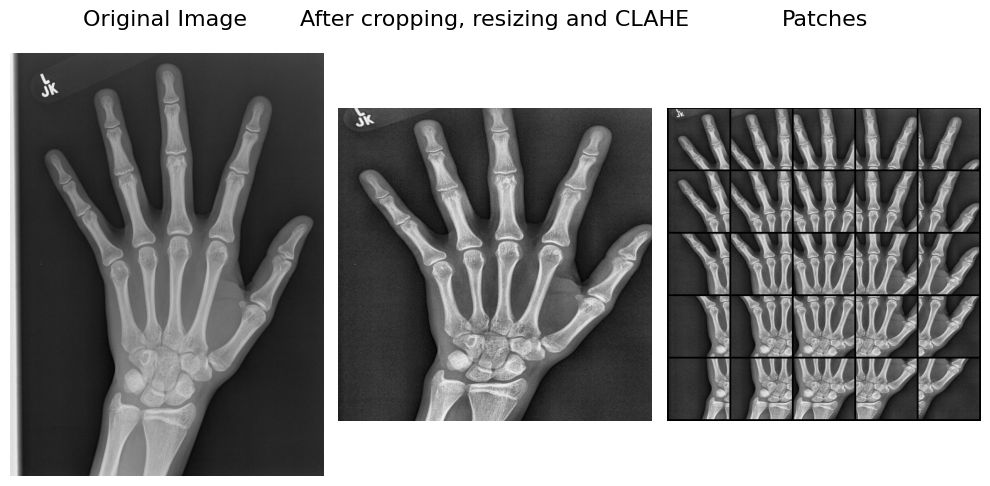

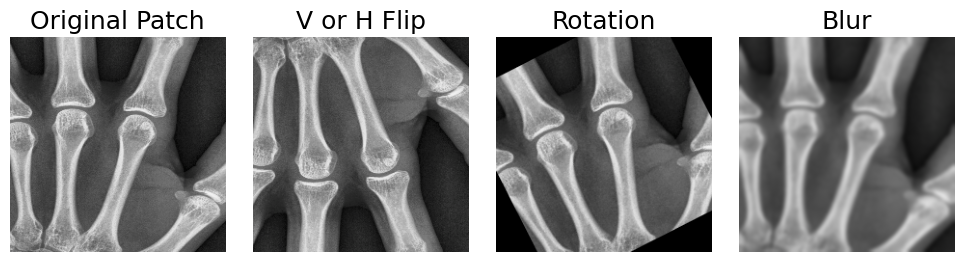

In [ ]:
plot_processed_image(os.path.join(test_path, 'images'), num_patches_per_side=5, fontsize=[16])

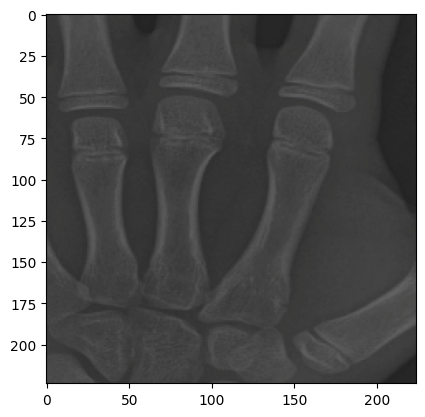

In [9]:
import matplotlib.pyplot as plt
plt.imshow(image[12])
plt.show()

In [ ]:
%%capture
# dummy run to initialize the model in prediction mode
dummy_image = tf.zeros_like(image)
dummy_gender = tf.zeros_like(gender)
_ = model.predict((dummy_image, dummy_gender), steps=1)

In [10]:
%%capture
start = time.time()
test_values = model.predict((image, gender), steps=1).squeeze()

median_loss = np.abs(age - np.median(test_values))
end = time.time()

In [ ]:
print("Difference between median prediction and true age of the children: ",  float(median_loss))
print(f"Inference time for one of {num_test_images} samples in test on {len(strategy.extended.worker_devices)}x{strategy.extended.worker_devices[0].split('/')[-1].split(':')[1]}: {end-start} seconds")

Difference between median prediction and true age of the children:  4.408233642578125
Inference time for one of 200 samples in test on 1xCPU: 8.955984354019165 seconds
